In [1]:
import numpy as np
import pandas as pd


import tensorflow as tf
import tensorflow_hub as hub

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import emoji
import re
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler


2023-06-29 21:08:44.699706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 21:08:47.809628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 21:08:47.834864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 21:08:53.657147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brijesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
MAX_LENGTH =  50
MAX_CURRENCY_FLAG = 2
MAX_SPAM_WORDS = 1
MAX_EMOJI = 2
MAX_CONATANS = 1
MAX_EMAIL= 1
MAX_PHONE = 1

In [3]:
df1 = pd.read_csv("./datasets/sms.csv",delimiter=',')
df2 = pd.read_csv("datasets/yt.csv",delimiter=',')
df3 = pd.read_csv("datasets/my-collection.csv",delimiter=',')
df4 = pd.read_csv("datasets/spam-word.csv",delimiter=',')
df5 = pd.read_csv("datasets/emoji.csv",delimiter=',')


df = pd.concat([df5],ignore_index=True)

In [4]:
class ConvertData:
    def fit(self, x, y=None):
        return self

    def transform(self, df):
        df = df.drop_duplicates()
        df = df.dropna()
        df["Spam"] = df["Spam"].astype(int)
        df["Comment"] = df["Comment"].astype(str)
        return df


class RemoveStopWordsPunctuation:
    def fit(self, x, y=None):
        return self

    def __remove_punctuation_stopwords(self, text):
        pattern = re.compile("[{}]".format(re.escape("!\"#&'()*,-/:;<=>?[\\]^_`{|}~")))
        text = " ".join(
            [
                word.strip()
                for word in pattern.sub(" ", text.lower()).split()
                if word not in set(stopwords.words("english"))
            ]
        )
        return text

    def transform(self, df):
        df["Comment"] = df["Comment"].apply(self.__remove_punctuation_stopwords)
        return df


class AddLengthFlag:
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X["length"] = X["Comment"].str.len().astype(float) / MAX_LENGTH
        return X


class AddCurrencyFlag:
    def __init__(self) -> None:
        self.currency_symbols = ["₤", "₨", "€", "₹", "₿", "$"]
        self.pattern = "([\$₤₨€₹₿]+ *[0-9]* *[\.,]?[0-9]*)|([0-9]* *[\.,]?[0-9]* *[\$₤₨€₹₿]+)"

    def fit(self, x, y=None):
        return self

    def __add_currency_count(self, text):
        return len(re.findall(self.pattern, text)) / MAX_CURRENCY_FLAG

    # def __add_currency_count(self,text):
    #     return sum(text.count(symbol) for symbol in self.currency_symbols )

    def transform(self, df):
        df["currency"] = df["Comment"].apply(self.__add_currency_count)
        return df


class AddSpamWordsFlag:
    def __init__(self) -> None:
        self.spam_words = [
            "urgent",
            "exclusive",
            "limited time",
            "free",
            "guaranteed",
            "act now",
            "discount",
            "special offer",
            "prize",
            "instant",
            "cash",
            "save",
            "win",
            "best",
            "secret",
            "incredible",
            "congratulations",
            "approved",
            "risk free",
            "hidden",
            "bonus",
            "sale",
            "amazing",
            "extra cash",
            "opportunity",
            "easy",
            "double your",
            "best price",
            "cash back",
            "deal",
            "earn",
            "money",
            "no obligation",
            "profit",
            "results",
            "exciting",
            "unbelievable",
            "jackpot",
            "fantastic",
            "instant access",
            "million dollars",
            "discounted",
            "last chance",
            "exclusive offer",
            "big savings",
            "limited offer",
            "free trial",
            "special promotion",
            "secret revealed",
            "valuable",
            "money-back guarantee",
            "lowest price",
            "save money",
            "make money",
            "no risk",
            "exclusive deal",
            "limited supply",
            "huge",
            "incredible offer",
            "prize winner",
            "earn extra income",
            "limited spots",
            "new offer",
            "best deal",
            "don't miss out",
            "great savings",
            "top offer",
            "double your income",
            "discount code",
            "fast cash",
            "top-rated",
            "best value",
            "no cost",
            "elite",
            "act fast",
            "unbeatable",
            "cash prize",
            "limited availability",
            "special discount",
            "quick cash",
            "no catch",
            "instant approval",
            "big discount",
            "easy money",
            "insider",
            "invitation",
            "free shipping",
            "huge discount",
            "extra income",
            "secret formula",
            "no strings attached",
            "money-making",
            "dream come true",
            "massive",
            "free gift",
            "incredible opportunity",
            "risk-free trial",
            "instant money",
            "special price",
            "no purchase necessary",
            "now",
        ]

    def fit(self, x, y=None):
        return self

    def __add_currency_count(self, text):
        return float(sum(text.count(symbol) for symbol in self.spam_words) / MAX_SPAM_WORDS)

    def transform(self, df):
        df["spam_word"] = df["Comment"].apply(self.__add_currency_count)
        return df


class AddEmojiFlag:
    def __init__(self) -> None:
        self.emoji_symbols = "[💭|🔝|🆗|🎉|🎊|📯|🙌|😂|💸|👉|📢|🚀|💲|💣|🔱|💼|🆙|⏳|✨|💌|💎|🆕|🔞|💡|💰|👑|⭐|🌟|🎤|⚡|📈|💵|🏆|💪|🔓|🆓|🎰|⌚|🚨|💢|📮|🔥|🎈|🎥|🔔|💯|🎶|🔗|🎁|📚|🔊|👍|👏|📱|📝|🤑|🏅|🔒|📣|💥]"

    def fit(self, x, y=None):
        return self

    def __add_currency_count(self, text):
        return float(len(re.findall(self.emoji_symbols, text)) / MAX_EMOJI)

    def transform(self, df):
        df["emoji"] = df["Comment"].apply(self.__add_currency_count)
        return df


class AddContainFlag:
    def fit(self, x, y=None):
        return self

    def __add_first_count(self, text):
        pattern = "[0-9]*%|T&C"
        return len(re.findall(pattern, text))

    def __add_second_count(self, text):
        pattern = "(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})(\.[a-zA-Z0-9]{2,})?"
        return len(re.findall(pattern, text))

    def transform(self, df):
        df["contain"] = df["Comment"].apply(self.__add_first_count)
        df["contain"] = df["contain"] + df["Comment"].apply(self.__add_second_count)
        df['contain'] = df['contain'] / MAX_CONATANS
        return df


class AddEmailFlag:
    def fit(self, x, y=None):
        return self

    def __add_email_count(self, text):
        pattern = "[\w]+@[\w]+\.\w+"
        return float(len(re.findall(pattern, text))  /MAX_EMAIL)

    def transform(self, df):
        df["email"] = df["Comment"].apply(self.__add_email_count)
        return df


class AddPhoneFlag:
    def fit(self, x, y=None):
        return self

    def __add_phone_no_count(self, text):
        pattern = "\+?[0-9]?[0-9]? ?0?[0-9]{10}"
        return len(re.findall(pattern, text))

    def __add_phone_no_count_1(self, text):
        pattern = "\+?[0-9]?\d{3}[ -]?\d{3}[ -]?\d{4}"
        return len(re.findall(pattern, text))

    def transform(self, df):
        df["phone"] = df["Comment"].apply(self.__add_phone_no_count)
        df["phone"] = df["phone"] + df["Comment"].apply(self.__add_phone_no_count_1)
        df["phone"] = df["phone"] / MAX_PHONE


        return df


class RemovePhoneLinkEmail:
    def fit(self, x, y=None):
        return self

    def __remove(self, text):
        text = re.sub("\$[0-9]*([\.,][0-9]{2})*\$?", "", text)
        text = re.sub("\+?[0-9]?[0-9]? ?0?[0-9]{10}", "", text)
        text = re.sub("\+?[0-9]?\d{3}[ -]?\d{3}[ -]?\d{4}", "", text)
        text = re.sub(
            r"(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})(\.[a-zA-Z0-9]{2,})?",
            "",
            text,
        )
        text = re.sub(r"[\w]+@[\w]+\.\w+", "", text)
        text = emoji.replace_emoji(text)
        return text

    def transform(self, df):
        df["Comment"] = df["Comment"].apply(self.__remove)
        return df


class LemmatizeText:
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def __lemmatize_text(self, text):
        return " ".join(
            [self.lemmatizer.lemmatize(word) for word in re.split("\W+", text)]
        ).strip()

    def transform(self, df):
        df["Comment"] = df["Comment"].map(lambda text: self.__lemmatize_text(text))
        return df



In [5]:


pipe =  Pipeline([
    ("ConvertData",ConvertData()),

    ("AddCurrencyFlag",AddCurrencyFlag()),
    ("AddSpamWordsFlag",AddSpamWordsFlag()),
    ("AddEmojiFlag",AddEmojiFlag()),
    ("AddContainFlag",AddContainFlag()),
    ("AddEmailFlag",AddEmailFlag()),
    ("AddPhoneFlag",AddPhoneFlag()),

    ("RemovePhoneLinkEmail",RemovePhoneLinkEmail()),
    ("RemoveStopWordsPunctuation",RemoveStopWordsPunctuation()),
    
    ("LemmatizeText",LemmatizeText()),

    ("AddLengthFlag",AddLengthFlag()),


])


In [6]:
df = pipe.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 626
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Comment    513 non-null    object 
 1   Spam       513 non-null    int64  
 2   currency   513 non-null    float64
 3   spam_word  513 non-null    float64
 4   emoji      513 non-null    float64
 5   contain    513 non-null    float64
 6   email      513 non-null    float64
 7   phone      513 non-null    float64
 8   length     513 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 40.1+ KB


,Comment,Spam,currency,spam_word,emoji,contain,email,phone,length
0,,1,0.0,0.0,0.5,0.0,0.0,0.0,0.00
1,,1,0.0,0.0,0.5,0.0,0.0,0.0,0.00
2,,1,0.0,0.0,0.5,0.0,0.0,0.0,0.00
3,,1,0.0,0.0,0.5,0.0,0.0,0.0,0.00
4,,1,0.0,0.0,0.5,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...
622,limited spot available investment seminar emai...,1,0.0,1.0,0.0,2.0,2.0,0.0,3.34
623,unlock potential personal development course e...,1,0.0,0.0,0.0,2.0,2.0,0.0,3.08
624,attention small business owner email u busines...,1,0.0,1.0,0.0,2.0,2.0,0.0,3.16
625,limited edition offer email u collectorseditio...,1,0.0,3.0,0.0,3.0,3.0,0.0,3.52


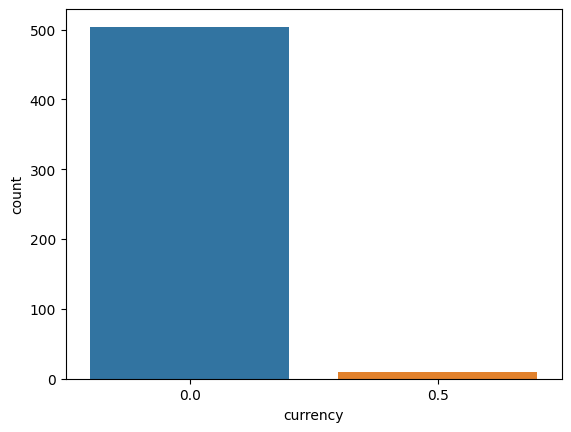

In [7]:
import seaborn as sns
sns.countplot(x="currency",data=df)
# sns.countplot(x="spam_word",data=df)
# sns.countplot(x="emoji",data=df)
# sns.countplot(x="contain",data=df)
# sns.countplot(x="email",data=df)
# sns.countplot(x="phone",data=df)
# sns.countplot(x="length",data=df)

df

In [8]:
y = pd.DataFrame(df.Spam)
x = df.drop(["Spam"],axis=1)

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)

X_train=[x_train["Comment"],x_train["length"],x_train["currency"] , x_train["spam_word"] , x_train["emoji"] , x_train["contain"], x_train["email"], x_train["phone"]]
X_test=[ [x_test["Comment"], x_test["length"],x_test["currency"] , x_test["spam_word"] , x_test["emoji"] , x_test["contain"], x_test["email"], x_test["phone"]]]

In [10]:

class LayerHelper(tf.keras.layers.Layer):
    def __init__(self, name1 ,name2 ,units1 = 8 ,units2 = 8 , dropout_rate=0.5 ):
        super(LayerHelper, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units1, activation='relu', name=name1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense2 = tf.keras.layers.Dense(units2, activation='relu', name=name2 )

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout(x)
        x = self.dense2(x)
        return x



class Comment(tf.keras.layers.Layer):
    def __init__(self):
        super(Comment, self).__init__()

        self.url = "https://tfhub.dev/google/nnlm-en-dim50/2"

        self.hub_layer = hub.KerasLayer(self.url, dtype=tf.string, trainable=True,name="NNLM_Hub")        
        
        self.set1= LayerHelper(name1="Comment_Dense_set_1",name2="Comment_Dense_set_1_out",units1=125000,units2=2500,dropout_rate=0.2)
        self.set2 = LayerHelper(name1="Comment_Dense_set_2",name2="Comment_Dense_set_2_out",units1=2500,units2=1250,dropout_rate=0.3)
        self.set3 = LayerHelper(name1="Comment_Dense_set_3",name2="Comment_Dense_set_3_out",units1=1250,units2=MAX_LENGTH,dropout_rate=0.3)
        
    def call(self, inputs):

        x = self.hub_layer(inputs)
        x = self.set1(x)
        x = self.set2(x)
        x = self.set3(x)

        return x




In [11]:

string_input = tf.keras.layers.Input(shape=[], dtype=tf.string , name="Comment")
length_input   = tf.keras.layers.Input(shape=(1,),name="Length",dtype=tf.float32)
currency_input = tf.keras.layers.Input(shape=(1,),name="Currency",dtype=tf.float32)
spam_word_input = tf.keras.layers.Input(shape=(1,),name="Spam Words",dtype=tf.float32)
emoji_input = tf.keras.layers.Input(shape=(1,),name="Emoji",dtype=tf.float32)
contain_input = tf.keras.layers.Input(shape=(1,),name="Contain",dtype=tf.float32)
email_input = tf.keras.layers.Input(shape=(1,),name="Email",dtype=tf.float32)
phone_input = tf.keras.layers.Input(shape=(1,),name="Phone",dtype=tf.float32)


comment_layer = Comment()(string_input)

length_layer    = LayerHelper("length_layer","length_layer_out",256,120,0.4)(length_input)
currency_layer  = LayerHelper("currency_layer","currency_layer_out",120,8,0.4)(currency_input)
spam_word_layer = LayerHelper("spam_word_layer","spam_word_layer_out",120,8,0.4)(spam_word_input)
emoji_layer     = LayerHelper("emoji_layer","emoji_layer_out",120,8,0.4)(emoji_input)
contain_layer   = LayerHelper("contain_layer","contain_layer_out",120,8,0.4)(contain_input)
email_layer     = LayerHelper("email_layer","email_layer_out",120,8,0.4)(email_input)
phone_layer     = LayerHelper("phone_layer","phone_layer_out",120,8,0.4)(phone_input)



concat_layer_level1_1 = tf.keras.layers.concatenate([length_layer,currency_layer,spam_word_layer])
concat_layer_level1_2 = tf.keras.layers.concatenate([contain_layer,emoji_layer,email_layer,phone_layer])


concat_layer_level1_1_dense = tf.keras.layers.Dense(24, activation='relu',name="concat_layer_level1_1_dense")(concat_layer_level1_1)
concat_layer_level1_2_dense = tf.keras.layers.Dense(32, activation='relu',name="concat_layer_level1_2_dense")(concat_layer_level1_2)

concat_layer_level = tf.keras.layers.concatenate([concat_layer_level1_1_dense,concat_layer_level1_2_dense])
sub_layer = tf.keras.layers.Dense(56, activation='relu',name="sub_layer")(concat_layer_level)
flags  = tf.keras.layers.Dropout(rate=0.1)(sub_layer)


concat_layer = tf.keras.layers.concatenate([comment_layer,flags ])

# Add dense and output layers
f1= tf.keras.layers.Dense(300, activation='relu')(concat_layer)
f2 = tf.keras.layers.Dense(150, activation='relu')(f1)
f3 = tf.keras.layers.Dense(100, activation='relu')(f2)
f4 = tf.keras.layers.Dense(64, activation='relu')(f3)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid',name="output")(f4)

# Create the model
model = tf.keras.Model(inputs=[string_input, length_input,currency_input,spam_word_input,emoji_input,contain_input,email_input,phone_input], outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=[])
model.summary()

2023-06-29 21:12:16.140765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 21:12:16.141454: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-29 21:12:16.988220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192762400 exceeds 10% of free system memory.
2023-06-29 21:12:17.944079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start abo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Length (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Currency (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Spam Words (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Contain (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

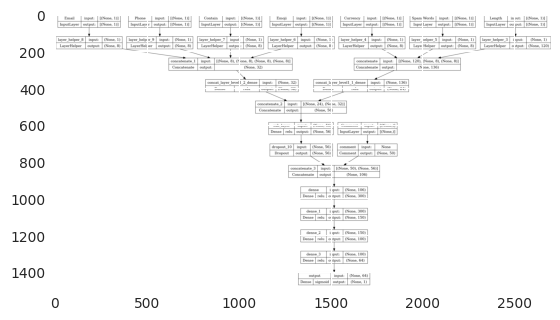

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='team_strength_model.png',show_shapes=1,expand_nested=1,show_layer_activations=1)

# Display the image
data = plt.imread('team_strength_model.png')
plt.imshow(data)



In [12]:

k = model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=32,
          verbose=1
)

Epoch 1/10


2023-06-29 21:13:28.147820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,50]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-06-29 21:13:28.147898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype int64 and shape [?]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-06-29 21:13:28.181397: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192762400 exceeds 10% of f